In [14]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image

Read in Dataset

In [15]:
root = "/home/amzeplin/plant_village_dataset"

In [16]:
tomato_class = os.path.join(root, "Tomato")
os.listdir(tomato_class)

['Val', 'Train', 'Test']

In [17]:
tomato_class = os.path.join(root, "Tomato", "Train")
os.listdir(tomato_class)

['Early Blight',
 'Bacterial Spot',
 'Yellow Leaf Curl Virus',
 'Septoria Leaf Spot',
 'Healthy',
 'Late Blight']

In [34]:
import torch
import os
from PIL import Image
from torchvision import transforms

class PlantVillage(torch.utils.data.Dataset):
    def __init__(self, root: str, split: str, transform=None):
        self.root = root
        self.species = os.listdir(self.root)
        self.img_split = split
        self.transform = transform
        self.data = self.__load_files()

        # ✅ Create label_map to map species_disease to a numeric index
        unique_labels = sorted(set(f"{species}_{disease}" for _, species, disease in self.data))
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file, species, disease_class = self.data[idx]
        img = Image.open(img_file).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # ✅ Convert label from string to tensor index
        label = self.label_map[f"{species}_{disease_class}"]
        label = torch.tensor(label, dtype=torch.long)

        return img, label

    def __load_files(self):
        data = []
        for specie in self.species:
            specie_path = os.path.join(self.root, specie, self.img_split)
            if not os.path.exists(specie_path): 
                continue

            for disease in os.listdir(specie_path):
                disease_path = os.path.join(specie_path, disease)
                if not os.path.isdir(disease_path):
                    continue

                images = [img for img in os.listdir(disease_path) if not img.startswith('.')]

                data.extend([(os.path.join(disease_path, img), specie, disease) for img in images])

        return data


Split up Train, Val, Test

In [35]:
train_augmentations = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.3),  # Reduce probability
    transforms.RandomRotation(5),  # Reduce rotation angle
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduce jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_ds = PlantVillage(
            root=root,
            split="Train",
            transform=train_augmentations,
        )

val_ds = PlantVillage(
            root=root,
            split="Val",
            transform=train_augmentations,
        )

test_ds = PlantVillage(
            root=root,
            split="Test",
            transform=train_augmentations,
        )

train_loader = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    num_workers=0,
    drop_last=False,
    persistent_workers=False,
    shuffle=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_ds,
    batch_size=32,
    num_workers=0,
    drop_last=True,
    persistent_workers=False,
    shuffle=False,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=32,
    num_workers=0,
    drop_last=True,
    persistent_workers=False,
    shuffle=False,
    pin_memory=True,
)

Creating Train, Val, Test Variables

In [20]:
img, label = train_ds[0]
print(img.shape)  # Should be (3, 224, 224)
print(label)      # Should be "species_disease"


torch.Size([3, 224, 224])
tensor(7)


Transformations

In [21]:
import torchvision.models as models
import torch.nn as nn

# ✅ Get the number of classes from label_map
num_classes = len(train_ds.label_map)

# ✅ Load EfficientNet-B3
model = models.efficientnet_b3(pretrained=True)

# ✅ Modify the classifier to match the number of classes
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)  # Output layer matches number of classes
)

# ✅ Move the model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduce LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # Gradually decrease LR
criterion = nn.CrossEntropyLoss()


Try two

In [22]:
# ✅ Define evaluate function BEFORE using it
def evaluate(model, loader):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples

    return 100 * correct / total  # Return accuracy percentage


# ✅ Train model function with Validation Accuracy added
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total  # Compute training accuracy

        # ✅ Compute validation accuracy after each epoch
        val_accuracy = evaluate(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")
    
    print("Training complete!")


# ✅ Start training with validation accuracy
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 505.8732, Train Accuracy: 92.91%, Val Accuracy: 99.43%
Epoch [2/5], Loss: 47.6413, Train Accuracy: 99.12%, Val Accuracy: 98.91%
Epoch [3/5], Loss: 30.8995, Train Accuracy: 99.42%, Val Accuracy: 98.51%
Epoch [4/5], Loss: 26.0082, Train Accuracy: 99.51%, Val Accuracy: 99.41%
Epoch [5/5], Loss: 27.5368, Train Accuracy: 99.50%, Val Accuracy: 99.44%
Training complete!


In [36]:
# Evaluate on the test dataset
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.55%


In [ ]:
torch.save(model, "efficientnet_plant_disease.pth")
print("Entire model saved successfully!")


In [43]:
import torchvision.transforms as transforms
from PIL import Image

# ✅ Define preprocessing (resize, normalize, convert to tensor)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    
    image = Image.open(image_path).convert("RGB")  # Ensure image is RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available


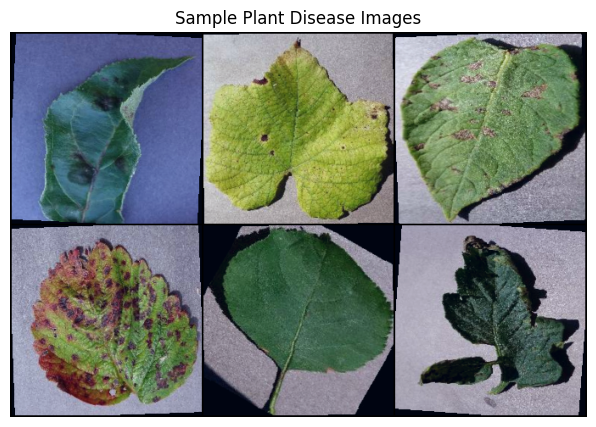

Image 1: Apple_Apple Scab
Image 2: Grape_Leaf Blight
Image 3: Potato_Early Blight
Image 4: Strawberry_Leaf Scorch
Image 5: Apple_Black Rot
Image 6: Tomato_Septoria Leaf Spot


In [58]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Function to display images from the dataset
def show_images_from_loader(loader, dataset, num_images=6):
    images, labels = next(iter(loader))  # Get a batch of images
    images = images[:num_images]  # Take only the first few images
    labels = labels[:num_images]

    # Convert images to numpy format for plotting
    img_grid = make_grid(images, nrow=3, normalize=True).numpy()
    img_grid = np.transpose(img_grid, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title("Sample Plant Disease Images")
    plt.show()

    # ✅ Convert label indices back to class names
    idx_to_label = {v: k for k, v in dataset.label_map.items()}  # Reverse mapping

    # ✅ Convert tensor label to integer before lookup
    for i, label in enumerate(labels):
        class_name = idx_to_label[label.item()]  # Convert tensor to int before lookup
        print(f"Image {i+1}: {class_name}")

# ✅ Show images from training dataset
show_images_from_loader(train_loader, train_ds)


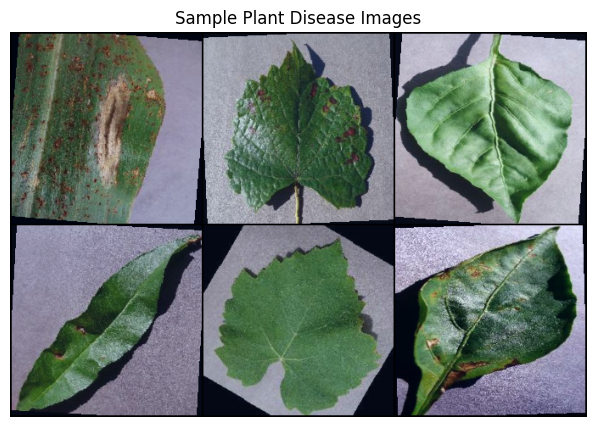

Image 1: True Label: Corn (Maize)_Northern Leaf Blight, Predicted: Corn (Maize)_Northern Leaf Blight --> Correct
Image 2: True Label: Grape_Esca (Black Measles), Predicted: Grape_Esca (Black Measles) --> Correct
Image 3: True Label: Bell Pepper_Healthy, Predicted: Bell Pepper_Healthy --> Correct
Image 4: True Label: Peach_Bacterial Spot, Predicted: Peach_Bacterial Spot --> Correct
Image 5: True Label: Grape_Healthy, Predicted: Grape_Healthy --> Correct
Image 6: True Label: Bell Pepper_Bacterial Spot, Predicted: Bell Pepper_Bacterial Spot --> Correct


In [61]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Function to display images and check accuracy
def show_images_with_accuracy(loader, dataset, num_images=6):
    images, labels = next(iter(loader))  # Get a batch of images
    images = images[:num_images]  # Take only the first few images
    labels = labels[:num_images]

    # Convert images to numpy format for plotting
    img_grid = make_grid(images, nrow=3, normalize=True).numpy()
    img_grid = np.transpose(img_grid, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title("Sample Plant Disease Images")
    plt.show()

    # ✅ Convert label indices back to class names
    idx_to_label = {v: k for k, v in dataset.label_map.items()}  # Reverse mapping

    # ✅ Get Model Predictions
    images = images.to("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        outputs = model(images)  # Run images through the model
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

    # ✅ Compare True Labels vs Predictions
    for i, (true_label, pred_label) in enumerate(zip(labels, preds)):
        true_class = idx_to_label[true_label.item()]
        predicted_class = idx_to_label[pred_label.item()]
        correctness = "Correct" if true_class == predicted_class else "Incorrect"

        print(f"Image {i+1}: True Label: {true_class}, Predicted: {predicted_class} --> {correctness}")

# ✅ Run the function
show_images_with_accuracy(train_loader, train_ds)


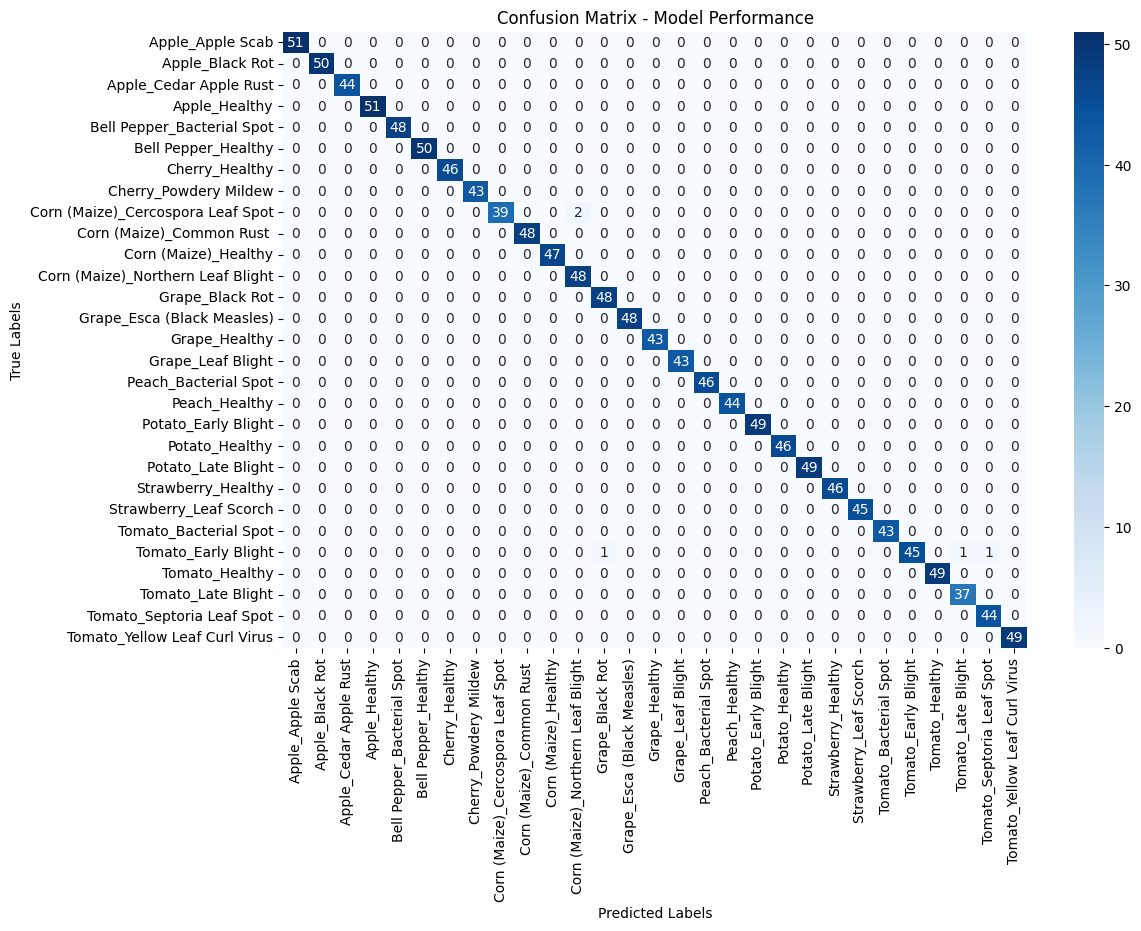

In [60]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ✅ Function to compute confusion matrix
def compute_confusion_matrix(model, loader, dataset):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # ✅ Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

# ✅ Compute confusion matrix on the test dataset
conf_matrix = compute_confusion_matrix(model, test_loader, train_ds)

# ✅ Get class names
idx_to_label = {v: k for k, v in train_ds.label_map.items()}  # Reverse mapping
class_names = list(idx_to_label.values())  # Get class labels

# ✅ Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Model Performance")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    
    if isinstance(image, str):  # If input is a file path, open the image
        image = Image.open(image).convert("RGB")
    
    image = transform(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    return image.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available




In [73]:
import requests
from io import BytesIO

def predict_from_url(image_url, model, dataset):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")  # ✅ Already an image object

    # ✅ No need to pass a file path, just use the image object
    processed_image = preprocess_image(image)  

    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)  # Get predicted class index

    # ✅ Convert index back to class label
    idx_to_label = {v: k for k, v in dataset.label_map.items()}  # Reverse mapping
    predicted_label = idx_to_label[predicted.item()]

    print(f"Predicted Label: {predicted_label}")
    return predicted_label

# ✅ Example: Test with an online image
image_url = "https://cropprotectionnetwork.org/image?s=%2Fimg%2Fhttp%2Fgeneral%2FGray-leaf-spot-Adam-Sisson-56-1643303403.jpg%2Fad9b6a6e3251dde00e020ba821f99db2.jpg&h=256&w=316&fit=cover"
predict_from_url(image_url, model, train_ds)


Predicted Label: Corn (Maize)_Cercospora Leaf Spot


'Corn (Maize)_Cercospora Leaf Spot'